In [201]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
from sns_toolbox.networks import Network #, AdditionNetwork (This would import the code that we remake here
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.neurons import  NonSpikingNeuronWithPersistentSodiumChannel
from sns_toolbox.renderer import render

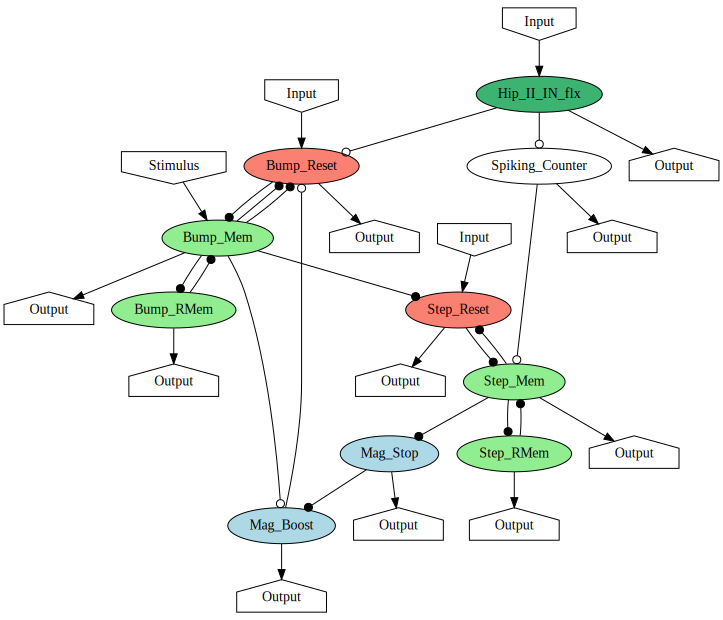

In [202]:
# Magnitude boost network

class Memory(Network):
    """
    Memory netwok
    :param name:        Name of this network and all neurons prefix. Should be Bump/Step/Gate. Default is 'Bump'.
    :type:              Can be Auto/Manual, Default is 'Auto'
        Auto network will automatically keep from resetting when it has a value, manual will autoreset unless the reset is suppressed otherwise
    """
    def __init__(self,name='Bump', type='Auto'):
        super().__init__(name=name)

        # Establish Key Variables

        Er = -60 # mV, resting potential, base state of neurons which they move off of
        Gm = 1 # uS
        R = 20 # mV, standing current applied to both integrator neurons to keep the system stable

        # Neuron variables based on table
        Cm = 5
        Es = -65 # Want synapse close to Er but a little less because close to modulatory is good but actually modulatory won't work
        delEs = Es-Er
        gs = -R/delEs

        intNeuron = NonSpikingNeuron(name="Int", color="lightgreen", membrane_capacitance=Cm, membrane_conductance=Gm, resting_potential=Er, bias=R)
        intSynapse = NonSpikingSynapse(max_conductance=gs, reversal_potential=Es, e_hi=-40, e_lo=-60)
        if name == 'Bump':
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=30, membrane_conductance=Gm, resting_potential=Er, bias=3)
        else:
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er, bias=3)
        # TriggerSynapse = NonSpikingSynapse(max_conductance=30, reversal_potential=0, e_hi=-35, e_lo=-55)
        InhSyn = NonSpikingSynapse(max_conductance=5, reversal_potential=-100, e_hi=-40, e_lo=-58) # max conductance mainly effects strength, reversal potential
        # mainly effects function, if inh then -100, if exc then 0
        # e_hi and e_lo determine the range over which the synapse activates
        ResetDoneSyn = NonSpikingSynapse(max_conductance=3, reversal_potential=-100, e_hi=-70, e_lo=-60)

        self.add_neuron(intNeuron, name+'_RMem')
        self.add_neuron(intNeuron, name+'_Mem')
        self.add_neuron(INNeuron, name+'_Reset')

        self.add_connection(intSynapse, name+'_RMem', name+'_Mem')
        self.add_connection(intSynapse, name+'_Mem', name+'_RMem')
        self.add_connection(InhSyn, name+'_Reset', name+'_Mem')
        self.add_connection(ResetDoneSyn, name+'_Mem', name+'_Reset')

        self.add_input(name+'_Reset', name='Input')

        if type == 'Auto':
            AntiResetSyn = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-100, e_hi=-50, e_lo=-57)
            self.add_connection(AntiResetSyn,name+'_Mem', name+'_Reset')
            if name == 'Bump':
                self.add_input(name+'_Mem', name='Stimulus')

        self.add_output(name+'_Mem')
        self.add_output(name+'_RMem')
        self.add_output(name+'_Reset')



net = Network('Magnitude Net')

# Establish Key Variables

Er = -60 # mV
Gm = 1 # uS
R = 20 # mV

# Add hip II flx
base_neuron = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60)
net.add_neuron(base_neuron, name='Hip_II_IN_flx', color='mediumseagreen') # As flx value increases, leg moves backward
net.add_input('Hip_II_IN_flx')
net.add_output('Hip_II_IN_flx')

Bump_Storage = Memory(name='Bump', type='Auto')
Step_Storage = Memory(name='Step', type='Manual')

net.add_network(Bump_Storage)
net.add_network(Step_Storage)

# Add connection to stop the step counter from resetting itself
AntiResetSyn = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-100, e_hi=-50, e_lo=-57)
net.add_connection(AntiResetSyn, 'Bump_Mem','Step_Reset')

StepCountSyn = NonSpikingSynapse(max_conductance=2.5, reversal_potential=0, e_hi=-30, e_lo=-50)
SpikingCounter = SpikingNeuron(membrane_capacitance=55,membrane_conductance=1,resting_potential=-60, threshold_time_constant=10, 
                               threshold_initial_value=-39, bias=8)
net.add_neuron(SpikingCounter, 'Spiking_Counter')
net.add_connection(StepCountSyn, 'Hip_II_IN_flx', 'Spiking_Counter')
SpikeCountSyn = SpikingSynapse(max_conductance=0.2, reversal_potential=0, time_constant=5, transmission_delay=0)
#SpikeCountSyn = NonSpikingSynapse(max_conductance=0.7, reversal_potential=0, e_hi=30, e_lo=-55)
net.add_connection(SpikeCountSyn, 'Spiking_Counter', 'Step_Mem')

# MAG STOP
MagStop = NonSpikingNeuron(membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er, bias=3)
net.add_neuron(MagStop, name='Mag_Stop', color='lightblue')
StepModSyn = NonSpikingSynapse(max_conductance=20, reversal_potential=-60, e_hi=-38, e_lo=-43)
net.add_connection(StepModSyn, 'Step_Mem', 'Mag_Stop')
net.add_output('Mag_Stop')

# MAG BOOST
MagBoostNeuron = NonSpikingNeuron(membrane_capacitance=10, membrane_conductance=Gm, resting_potential=Er)
net.add_neuron(MagBoostNeuron, name='Mag_Boost', color='lightblue')
ModSyn = NonSpikingSynapse(max_conductance=50, reversal_potential=-60, e_hi=-55, e_lo=-59)
net.add_connection(ModSyn, 'Mag_Stop','Mag_Boost')
BumpExc = NonSpikingSynapse(max_conductance=0.05, reversal_potential=0, e_hi=-40, e_lo=-60)
net.add_connection(BumpExc,'Bump_Mem', 'Mag_Boost')
net.add_output('Mag_Boost')

# RESET SYSTEM
BoostReset = NonSpikingSynapse(max_conductance=0.45, reversal_potential=0, e_hi=-40, e_lo=-59.5)
net.add_connection(BoostReset, 'Mag_Boost', 'Bump_Reset')
# HipResetExc = NonSpikingSynapse(max_conductance=0.5, reversal_potential=0, e_hi=-65, e_lo=-52.5)
HipResetExc = NonSpikingSynapse(max_conductance=0.1, reversal_potential=0, e_hi=-30, e_lo=-50)
net.add_connection(HipResetExc, 'Hip_II_IN_flx', 'Bump_Reset')

net.add_output('Spiking_Counter')

render(net)


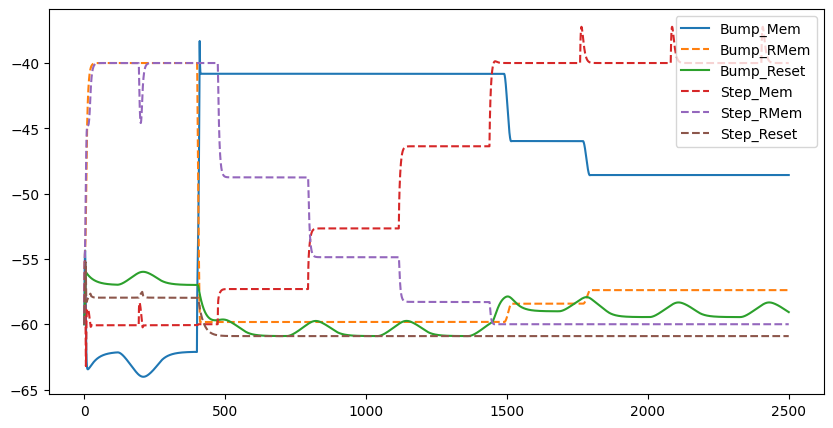

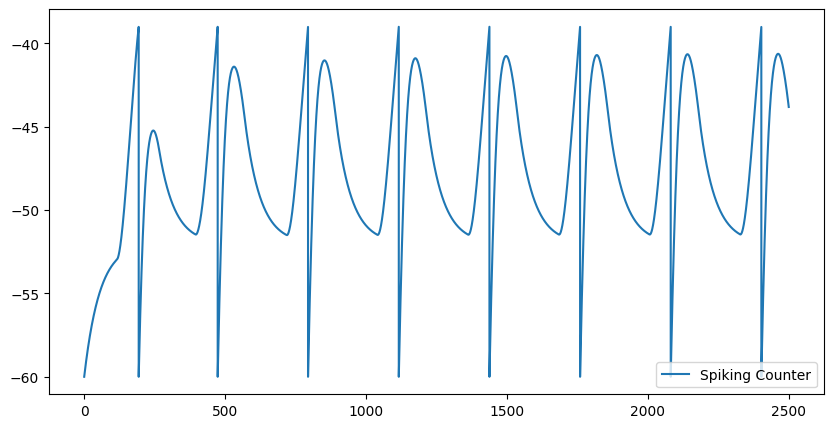

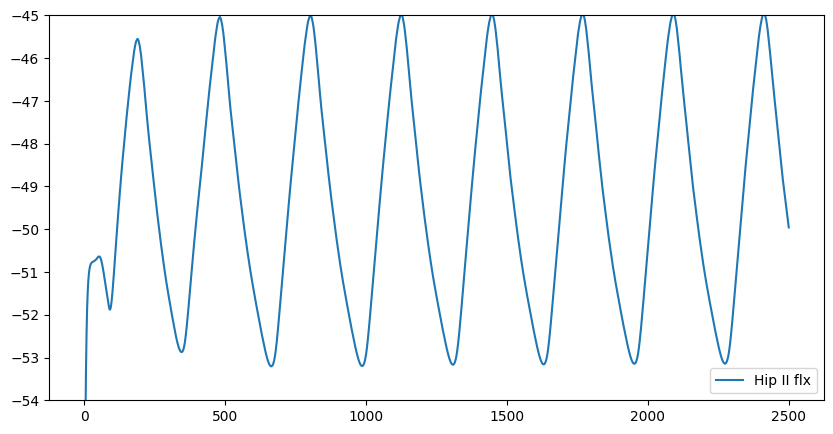

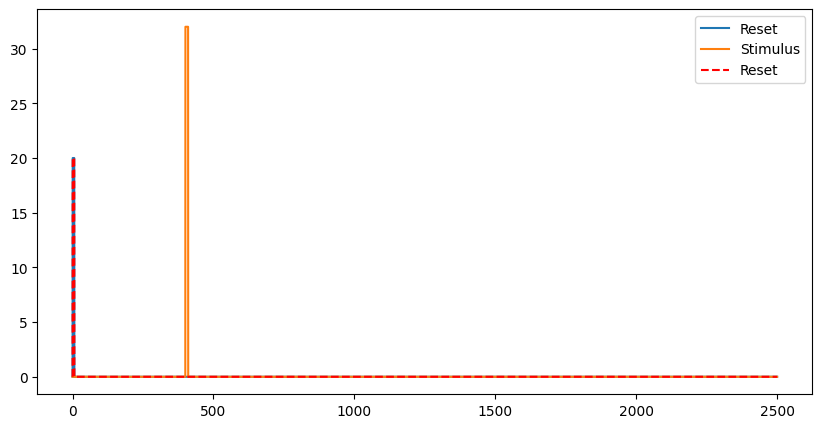

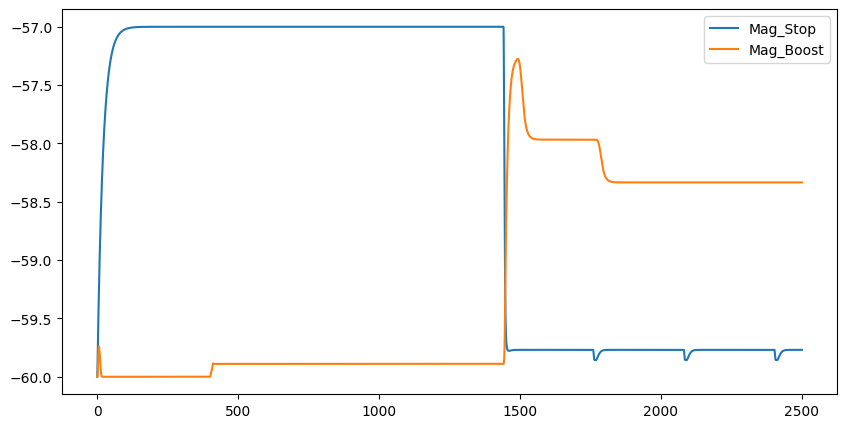

In [203]:
# Run the network

t_max = 2500 #ms
dt = 0.075 # ms
t = np.arange(0,t_max, dt)

Hip_flx_feedback = np.loadtxt('Hip_flx_feedback_Snapshot.txt')*1.02

MagNet = net.compile(backend='numpy',dt = dt)
numOut = MagNet.num_outputs
numIn = MagNet.num_inputs

data = np.zeros([len(t),numOut])
ins = np.zeros([len(t),numIn])
for i in range(1,int(6/dt)):
    ins[int(i+0/dt),[1,3]] = ins[int(i+0/dt),[1,3]] + 20 # Initialize memory
for i in range(1,int(10/dt)):
    ins[int(i+400/dt),2] = ins[int(i+400/dt),2] + 32 # 28 to 32 for min to max stimulus

for i in range(1,len(ins)):
    ins[i,0] = Hip_flx_feedback[i]

for i in range(1,len(t)):
    data[i,:] = MagNet(ins[i,:])

data[0]=np.zeros(numOut)-60

plt.figure(figsize=(10,5))
plt.plot(t, data[:,1], label='Bump_Mem')
plt.plot(t, data[:,2], label='Bump_RMem',linestyle="dashed")
plt.plot(t, data[:,3], label='Bump_Reset')
plt.plot(t, data[:,4], label='Step_Mem',linestyle="dashed")
plt.plot(t, data[:,5], label='Step_RMem',linestyle="dashed")
plt.plot(t, data[:,6], label='Step_Reset',linestyle="dashed")
plt.legend(loc='upper right')

plt.figure(figsize=(10,5))
plt.plot(t, data[:,9], label='Spiking Counter')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(t, data[:,0], label='Hip II flx')
plt.ylim(-54,-45)
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(t, ins[:,1], label='Reset')
plt.plot(t, ins[:,2], label='Stimulus')
plt.plot(t, ins[:,3], label='Reset', linestyle="dashed", color="red")
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(t, data[:,7], label='Mag_Stop')
plt.plot(t, data[:,8], label='Mag_Boost')
plt.legend()